# 02- Machine learning
This notebook will analyze the files created in 01. 
First several models will be trained to predict pChEMBL values. Before using these models to compare the values of new ligands to the reference ligand the performance of these models will be evaluated. 

This lab is in part adapted from TeachOpenCADD


In [2]:
# We will load some libraries again first

from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

#from teachopencadd.utils import seed_everything

# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22
#seed_everything(SEED)

In [3]:
import os
from pathlib import Path
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Cheminformatics')
except:
    print("Directory already exists")
os.chdir('Cheminformatics')

Directory already exists


In [4]:
CHEMBLID = 'CHEMBL1952' # This is CHEMBL ID of the target
FILENAME = '../Projectmap_UMP.git/CHEMBL_1952.tsv' # The filename of the uploaded file

data = pd.read_csv(FILENAME, sep='\t')

print("There are a total of {} datapoints in this set".format(len(data)))
data.head()

There are a total of 1651 datapoints in this set


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
0,CHEMBL61708,NaN,NaN,428.41,1.0,0.91,6,Nc1nc(O)c2c(CNc3ccc(C(=O)N[C@@H](CCC(=O)O)C(=O...,IC50,'=',...,SINGLE PROTEIN,CHEMBL1134503,1,Scientific Literature,J Med Chem,2001,NaN,NaN,NaN,NaN
1,CHEMBL349723,NaN,NaN,285.33,0.0,2.17,25,Cc1ccc2nc(N)nc(O)c2c1Sc1ccnnc1,Ki,'=',...,SINGLE PROTEIN,CHEMBL1126619,1,Scientific Literature,J Med Chem,1993,NaN,NaN,NaN,NaN
2,CHEMBL164289,NaN,NaN,299.36,0.0,3.20,10,COc1ccc2nc(C)nc(O)c2c1Sc1ccncc1,Ki,'=',...,SINGLE PROTEIN,CHEMBL1126619,1,Scientific Literature,J Med Chem,1993,NaN,NaN,NaN,NaN
3,CHEMBL433923,NaN,NaN,451.55,0.0,1.88,30,C#CCN(Cc1ccc2nc(C)nc(O)c2c1)c1ccc(S(=O)(=O)N2C...,Kis,'=',...,SINGLE PROTEIN,CHEMBL1129494,1,Scientific Literature,J Med Chem,1996,NaN,NaN,NaN,NaN
4,CHEMBL171706,NaN,NaN,433.53,0.0,4.50,35,CCN(Cc1ccc2nc(C)nc(O)c2c1)c1ccc(S(=O)(=O)c2ccc...,Kii,'=',...,SINGLE PROTEIN,CHEMBL1129494,1,Scientific Literature,J Med Chem,1996,NaN,NaN,NaN,NaN


This has a lot of information and  we only need the compound ID, pCHEMBL_value, Assay Type, binding affinity and the smiles:

In [5]:
pd_data = data[['Molecule ChEMBL ID','pChEMBL Value','Smiles','Assay Type', 'Standard Relation','Standard Value']]
pd_data.rename(columns={'pChEMBL Value': 'pChEMBL_value', 'Assay Type':'Assay_Type'}, inplace=True)
pd_data.head()

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value
0,CHEMBL61708,5.34,Nc1nc(O)c2c(CNc3ccc(C(=O)N[C@@H](CCC(=O)O)C(=O...,B,'=',4600.000
1,CHEMBL349723,7.89,Cc1ccc2nc(N)nc(O)c2c1Sc1ccnnc1,B,'=',13.000
2,CHEMBL164289,6.58,COc1ccc2nc(C)nc(O)c2c1Sc1ccncc1,B,'=',260.000
3,CHEMBL433923,NaN,C#CCN(Cc1ccc2nc(C)nc(O)c2c1)c1ccc(S(=O)(=O)N2C...,B,'=',0.063
4,CHEMBL171706,NaN,CCN(Cc1ccc2nc(C)nc(O)c2c1)c1ccc(S(=O)(=O)c2ccc...,B,'=',0.130


Next, we will add an activity classifier, there is a lot of censored data in the set and these typically are compounds that only bind weakly! We still want to know about those non-binders and set our activity threshold at PChEMBL > 6.5 for the actives. 

In [6]:
import numpy as np
# Add column for activity
pd_data["active"] = np.zeros(len(pd_data))

# Mark every molecule as active with an pCHEMBL of >= 6.5, 0 otherwise
pd_data.loc[pd_data[pd_data.pChEMBL_value >= 6.5].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(pd_data.active.sum()))
print("Number of inactive compounds:", len(pd_data) - int(pd_data.active.sum()))

Number of active compounds: 323
Number of inactive compounds: 1328


Finally, we will drop functional assay readout, this is data that we don't want to consider in our model.

In [7]:
pd_data.drop(pd_data[pd_data.Assay_Type != 'B'].index, inplace=True)

print("We have a total of {} activity points left".format(len(pd_data)))

We have a total of 1625 activity points left


In [8]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

#### Molecule encoding

Now we define a function `smiles_to_fp` to generate fingerprints from SMILES.


In [9]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    try:
        mol = Chem.MolFromSmiles(smiles)
        
    except:
        return('NaN')

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [10]:
compound_df = pd_data.copy()

In [11]:
# Add column for fingerprint
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp)
compound_df.drop(compound_df[pd.isna(compound_df["fp"])].index, inplace=True)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value,active,fp
0,CHEMBL61708,5.34,Nc1nc(O)c2c(CNc3ccc(C(=O)N[C@@H](CCC(=O)O)C(=O...,B,'=',4600.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL349723,7.89,Cc1ccc2nc(N)nc(O)c2c1Sc1ccnnc1,B,'=',13.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL164289,6.58,COc1ccc2nc(C)nc(O)c2c1Sc1ccncc1,B,'=',260.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Machine Learning (ML)

In the following, we will try several ML approaches to classify our molecules. We will use:

* Random Forest (RF)
* Support Vector Machine (SVM) 
* Artificial Neural Network (ANN) 

Afterwards we will comment on the performence. The goal is to test the ability of the model to predict data which it has never seen before in order to flag problems known as over fitting and to assess the generalization ability of the model.

The dataset has 1625 datapoints, which is quite low to train a model. 


#### Helper functions
Helper function to plot customized ROC curves. Code inspired by [stackoverflow](https://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python).

In [12]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=True):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"results/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

Helper function to calculate model performance.

In [13]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [14]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

**Preprocessing**: Split the data (will be reused for the other models)
We will use a random split as this is what the example machine learning did and we were not yet able to encode a temporal split.

In [15]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 1300
Test data size: 325


#### Random forest classifier

We start with a random forest classifier, where we first set the parameters.

We train the model on a random train-test split and plot the results.

In [16]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [17]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.61
Specificity: 0.93
AUC: 0.92


*Model performance evaluation*

The model has an AUC of 0.92, a good score. 

Directory already exists, continuing


'/home/jovyan/Cheminformatics/results/roc_auc.png'

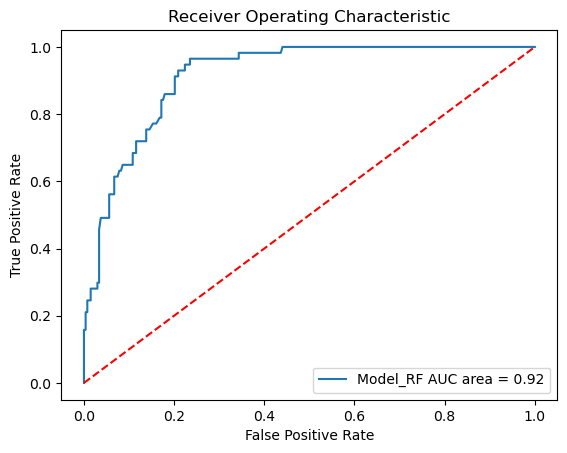

In [18]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
try:
    os.mkdir('results')
except:
    print("Directory already exists, continuing")
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

#### Support vector classifier
Here we train a SVM with a radial-basis function kernel (also: squared-exponential kernel).

In [19]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.61
Specificity: 0.95
AUC: 0.89


*Model performance evaluation*

The model has an AUC of 0.89, a good score, but a bit lower compared to the random forest model. 

'/home/jovyan/Cheminformatics/results/roc_auc.png'

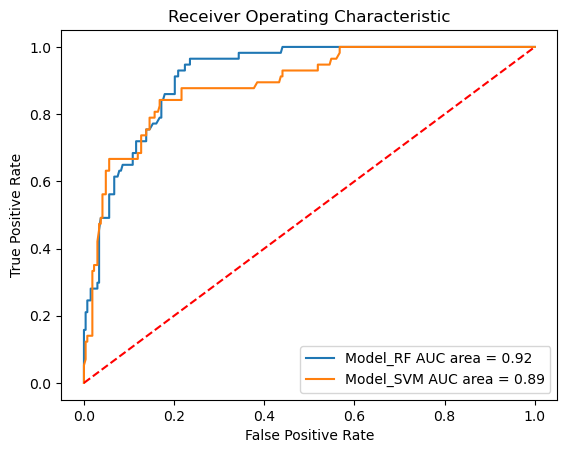

In [20]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

#### Neural network classifier
The last approach we try here is a neural network model. We train an MLPClassifier (Multi-layer Perceptron classifier) with 3 layers, each with 5 neurons. As before, we do the crossvalidation procedure and plot the results. For more information on MLP, see [sklearn MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

In [21]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=12)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.65
Specificity: 0.94
AUC: 0.90


*Model performance evaluation*

The model has an AUC of 0.90, a good score. 

'/home/jovyan/Cheminformatics/results/roc_auc.png'

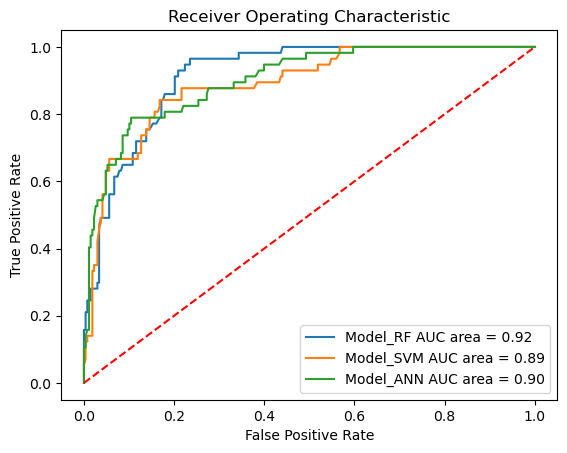

In [22]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

Our models show good/very good values for measured values (see AUCs) (very good >0,90, good 0,80-0,90) and thus seem to be predictive. The random forest model seems to be te most predictive with a score of 0,92 but all models have a similar AUC. 

#### Cross-validation


In [23]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

**Cross-validation**

We now apply cross-validation and show the statistics for all three ML models. In real world conditions, cross-validation usually applies 5 or more folds, but for the sake of performance we will reduce it to 3. You can change the value of `N_FOLDS` in this cell below.

In [24]:
N_FOLDS = 3

_Note_: Next cell takes long to execute

In [25]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.85 	and std : 0.02 
Mean sensitivity: 0.55 	and std : 0.04 
Mean specificity: 0.92 	and std : 0.01 
Mean AUC: 0.87 	and std : 0.02 
Time taken : 0.71s


Model_SVM
Mean accuracy: 0.86 	and std : 0.02 
Mean sensitivity: 0.53 	and std : 0.05 
Mean specificity: 0.94 	and std : 0.01 
Mean AUC: 0.86 	and std : 0.01 
Time taken : 1.57s


Model_ANN
Mean accuracy: 0.85 	and std : 0.02 
Mean sensitivity: 0.49 	and std : 0.03 
Mean specificity: 0.94 	and std : 0.01 
Mean AUC: 0.88 	and std : 0.02 
Time taken : 21.41s



We look at the cross-validation performance for molecules encoded using Morgan fingerprint and not MACCS keys.

In [26]:
# Reset data frame
compound_df = compound_df.drop(['fp'], axis=1)

In [27]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

[11:41:57] DEPRECATION WARNING: please use MorganGenerator
[11:41:57] DEPRECATION WARNING: please use MorganGenerator
[11:41:57] DEPRECATION WARNING: please use MorganGenerator
[11:41:57] DEPRECATION WARNING: please use MorganGenerator
[11:41:57] DEPRECATION WARNING: please use MorganGenerator
[11:41:57] DEPRECATION WARNING: please use MorganGenerator
[11:41:57] DEPRECATION WARNING: please use MorganGenerator
[11:41:57] DEPRECATION WARNING: please use MorganGenerator
[11:41:57] DEPRECATION WARNING: please use MorganGenerator
[11:41:57] DEPRECATION WARNING: please use MorganGenerator
[11:41:57] DEPRECATION WARNING: please use MorganGenerator
[11:41:57] DEPRECATION WARNING: please use MorganGenerator
[11:41:57] DEPRECATION WARNING: please use MorganGenerator
[11:41:57] DEPRECATION WARNING: please use MorganGenerator
[11:41:57] DEPRECATION WARNING: please use MorganGenerator
[11:41:57] DEPRECATION WARNING: please use MorganGenerator
[11:41:57] DEPRECATION WARNING: please use MorganGenerat

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value,active,fp
0,CHEMBL61708,5.34,Nc1nc(O)c2c(CNc3ccc(C(=O)N[C@@H](CCC(=O)O)C(=O...,B,'=',4600.0,0.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL349723,7.89,Cc1ccc2nc(N)nc(O)c2c1Sc1ccnnc1,B,'=',13.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL164289,6.58,COc1ccc2nc(C)nc(O)c2c1Sc1ccncc1,B,'=',260.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


_Note_: Next cell takes long to execute

In [28]:
for model in models:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        continue
    print("\n=======")
    print(model["label"])
    reduced_df = compound_df[['active','fp']]
    crossvalidation(model["model"], reduced_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.86 	and std : 0.02 
Mean sensitivity: 0.60 	and std : 0.08 
Mean specificity: 0.93 	and std : 0.01 
Mean AUC: 0.90 	and std : 0.02 
Time taken : 2.16s


Model_ANN
Mean accuracy: 0.86 	and std : 0.02 
Mean sensitivity: 0.60 	and std : 0.08 
Mean specificity: 0.93 	and std : 0.00 
Mean AUC: 0.90 	and std : 0.03 
Time taken : 49.70s



In [29]:
def crossvalidation_reg(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    MAE_per_fold = []
    RMSE_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].pChEMBL_value.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].pChEMBL_value.tolist()
        
        test_results = fold_model.predict(test_x)
        # Prediction probability on test set
        from sklearn import metrics

        MAE_per_fold.append(metrics.mean_absolute_error(test_y, test_results))
        #print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_y, test_results))
        RMSE_per_fold.append(np.sqrt(metrics.mean_squared_error(test_y, test_results)))
        #mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
        #print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
        #print('Accuracy:', round(100*(1 - mape), 2))
    return(MAE_per_fold,RMSE_per_fold,fold_model)

Next, make new data and run.

In [30]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.pChEMBL_value.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 1300
Test data size: 325


In [31]:
# Kick out NaN in the pChEMBL values
compound_df_noNaN = compound_df.dropna()

# Append RF Regressor model
#models.append({"label": "Model_RF_reg", "model": RandomForestRegressor})
#Train model with RandomForestRegressor
regressor = RandomForestRegressor()
MAE, RMSE,trained_model = crossvalidation_reg(regressor , compound_df_noNaN, n_folds=N_FOLDS)

print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
)

MAE: 0.55 	and std : 0.02 
RMSE: 0.78 	and std : 0.02 



The Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) values of 0.55 and 0.78, respectively, indicate that our model is performing well. Additionally, the standard deviation of 0.02 suggests that these predictions are highly reliable.

## Testing created ligands
The first entry is the co-crystalized ligand which is added for reference (so we can compare to its actual pChEMBL value) and below this we added our own molecules. In the second entry the molecules we have selected for the docking procedure are listed. These ligands are compared to the reference in the docking chapter, in which the changes can also be seen visually. 

In [32]:

test_smiles = [
    
    'C1[C@@H]([C@H](O[C@H]1N2C=CC(=O)NC2=O)COP(=O)(O)O)O', #reference
    '[H]O[P@](F)(OC([H])([C@@](O[C@]1(N2C([H])=C(C(N(C2=O)[H])=O)[H])[H])([C@@](O[H])([C@@](O)1[H])[H])[H])[H])=O',    
    'O=P(O)(O)OC([H])([C@@](O[C@]1(N2C([H])=C(C(N(C2=O)[H])=O)F)[H])([C@@](O[H])([C@@](O)1[H])[H])[H])',    
    '[H]OP(O[H])(OC([H])([C@@](O[C@]1(N2C([H])=C(C(N(C2=O)[H])=O)[H])[H])([C@@](O[H])([C@@](F)1[H])[H])[H])[H])=O',
    'O=C(N1[H])N([C@@]2([H])C([H])([H])[C@@](O[H])([H])[C@](C([H])([H])O[P@@](F)(O[H])=O)([H])O2)C([H])=C([H])C1=O',
    'O=C(N1[H])N([C@@]2([H])C([H])([H])[C@@](O[H])([H])[C@](C([H])([H])OS(O[H])(O[H])=O)([H])O2)C([H])=C([H])C1=O', 
    'O=C(N1[H])N([C@@]2([H])[C@@](N)([H])[C@@](O[H])([H])[C@](C([H])([H])OP(O[H])(O[H])=O)([H])O2)C([H])=C([H])C1=O' ,
    'O=C(N1[H])N([C@@]2([H])[C@@](N)([H])[C@@](O[H])([H])[C@](C([H])([H])O[P@@](F)(O[H])=O)([H])O2)C([H])=C([H])C1=O',
    'O=C(N1[H])N([C@@]2([H])C([H])([H])[C@@](C[H])([H])[C@](C([H])([H])OP(O[H])(O[H])=O)([H])O2)C([H])=C([H])C1=O', 
    'O=C(N1[H])C([H])=CN([C@@]2([H])C([H])([H])[C@@](O[H])([H])[C@](C([H])([H])OP(O[H])(O[H])=O)([H])O2)C1=O', 
    'O=C(N1[H])N([C@@]2([H])C([H])([H])[C@@](O[H])([H])[C@](C([H])([H])OP(O[H])(O[H])=O)([H])O2)C(O)=C([H])C1=O',
    'O=C(N1[H])N([C@@]2([H])[C@@](O)([H])[C@@](O[H])([H])[C@](C([H])([H])O[P@@](F)(O[H])=O)([H])O2)C(O)=C(O)C1=O',
    'O=C1N=C(O)N([C@@]2([H])[C@@](O)([H])[C@@](O[H])([H])[C@](C([H])([H])O[P@@](F)(O[H])=O)([H])O2)C(O)=C1[H]',
    'O=C(N1[H])N([C@@]2([H])[C@@](O)([H])[C@@](O[H])([H])[C@](C([H])([H])O[P@@](F)(O[H])=O)([H])O2)C(O)=C(F)C1=O',
    'O=C(N1[H])N([C@@]2([H])[C@@](O)(F)[C@@](O[H])([H])[C@](C([H])([H])O[P@@](F)(O[H])=O)([H])O2)C(O)=C([H])C1=O',
    'O=C(N1[H])N([C@@]2([H])[C@@](O)(F)[C@@](O[H])(F)[C@](C([H])([H])O[P@@](F)(O[H])=O)([H])O2)C(O)=C([H])C1=O',
    '[H]O[P@](F)(OC([H])([C@@](O[C@]1(N2C(O)=C(C(N(C2=O)[H])=O)[H])[H])([C@@](O[H])([C@@](O)1F)[H])[H])[H])=O',
    '[H]O[P@](F)(OC([H])([C@@](O[C@]1(N2C(O)=C([C@@](N(C2=O)[H])(C)O)[H])[H])([C@@](O[H])([C@@](O)1[H])[H])[H])[H])=O',
    'O=C(N1[H])N([C@@]2([H])C([H])([H])C([C@](C([H])([H])OP(O[H])(O[H])=O)([H])O2)=O)C([H])=C([H])C1=O', 
    'O=C(N1[H])N([C@@]2([H])C([H])([H])[C@@](O[H])([H])[C@](C([H])([H])OP(O[H])(O[H])=O)([H])C2)C([H])=C([H])C1=O', 
    'O=C1N([C@@]2([H])C([H])([H])[C@@](O[H])([H])[C@](C([H])([H])OP(O[H])(O[H])=O)([H])O2)C([H])=C([H])C(O)N1[H]',
    'O=C(N1[H])N([C@@]2([H])C([H])([H])[C@@](O[H])([H])[C@](C([H])([H])OP(O)(O[H])=O)([H])O2)C([H])=C([H])C1=O',
    '[H]C(OP(=O)=O)([C@@](O[C@]1(N2C([H])=C(C(N(C2=O)[H])=O)[H])[H])([C@@](O[H])([C@@](O)1[H])[H])[H])[H]',
    '[H]OP(O[H])(OC([H])([C@@](O[C@]1(N2C([H])=C([C@@H](O[H])N(C2=O)[H])[H])[H])([C@@](O[H])([C@@](O)1[H])[H])[H])[H])=O',
    '[H]OS(=O)(OC([H])([C@@](O[C@]1(N2C(O)=C([C@@](N(C2=O)[H])(C)O)[H])[H])([C@@](O[H])([C@@](O)1[H])[H])[H])[H])=O',
    'O=C(N1[H])N([C@@]2([H])[C@@](O)([H])[C@@](O[H])([H])[C@](C([H])([H])OP(O)(O[H])F)([H])O2)C(O)=C([H])C1=O'
]

fps = []

for smiles in test_smiles: 
    fp = smiles_to_fp(smiles,'morgan3')
    fps.append(fp)

predictions = trained_model.predict(fps)
print("SMILES, PREDICTION")
for i, prediction in enumerate(predictions):
    print('{},{:.2f}'.format(test_smiles[i], prediction))

SMILES, PREDICTION
C1[C@@H]([C@H](O[C@H]1N2C=CC(=O)NC2=O)COP(=O)(O)O)O,5.31
[H]O[P@](F)(OC([H])([C@@](O[C@]1(N2C([H])=C(C(N(C2=O)[H])=O)[H])[H])([C@@](O[H])([C@@](O)1[H])[H])[H])[H])=O,5.20
O=P(O)(O)OC([H])([C@@](O[C@]1(N2C([H])=C(C(N(C2=O)[H])=O)F)[H])([C@@](O[H])([C@@](O)1[H])[H])[H]),6.03
[H]OP(O[H])(OC([H])([C@@](O[C@]1(N2C([H])=C(C(N(C2=O)[H])=O)[H])[H])([C@@](O[H])([C@@](F)1[H])[H])[H])[H])=O,5.12
O=C(N1[H])N([C@@]2([H])C([H])([H])[C@@](O[H])([H])[C@](C([H])([H])O[P@@](F)(O[H])=O)([H])O2)C([H])=C([H])C1=O,5.36
O=C(N1[H])N([C@@]2([H])C([H])([H])[C@@](O[H])([H])[C@](C([H])([H])OS(O[H])(O[H])=O)([H])O2)C([H])=C([H])C1=O,5.27
O=C(N1[H])N([C@@]2([H])[C@@](N)([H])[C@@](O[H])([H])[C@](C([H])([H])OP(O[H])(O[H])=O)([H])O2)C([H])=C([H])C1=O,4.82
O=C(N1[H])N([C@@]2([H])[C@@](N)([H])[C@@](O[H])([H])[C@](C([H])([H])O[P@@](F)(O[H])=O)([H])O2)C([H])=C([H])C1=O,4.87
O=C(N1[H])N([C@@]2([H])C([H])([H])[C@@](C[H])([H])[C@](C([H])([H])OP(O[H])(O[H])=O)([H])O2)C([H])=C([H])C1=O,5.22
O=C(N1[H])C([H])=

[11:43:27] DEPRECATION WARNING: please use MorganGenerator
[11:43:27] DEPRECATION WARNING: please use MorganGenerator
[11:43:27] DEPRECATION WARNING: please use MorganGenerator
[11:43:27] DEPRECATION WARNING: please use MorganGenerator
[11:43:27] DEPRECATION WARNING: please use MorganGenerator
[11:43:27] DEPRECATION WARNING: please use MorganGenerator
[11:43:27] DEPRECATION WARNING: please use MorganGenerator
[11:43:27] DEPRECATION WARNING: please use MorganGenerator
[11:43:27] DEPRECATION WARNING: please use MorganGenerator
[11:43:27] DEPRECATION WARNING: please use MorganGenerator
[11:43:27] DEPRECATION WARNING: please use MorganGenerator
[11:43:27] DEPRECATION WARNING: please use MorganGenerator
[11:43:27] DEPRECATION WARNING: please use MorganGenerator
[11:43:27] DEPRECATION WARNING: please use MorganGenerator
[11:43:27] DEPRECATION WARNING: please use MorganGenerator
[11:43:27] DEPRECATION WARNING: please use MorganGenerator
[11:43:27] DEPRECATION WARNING: please use MorganGenerat

In [34]:

test_smiles = [
    
    'C1[C@@H]([C@H](O[C@H]1N2C=CC(=O)NC2=O)COP(=O)(O)O)O', #reference
    'O=P(O)(O)OC([H])([C@@](O[C@]1(N2C([H])=C(C(N(C2=O)[H])=O)F)[H])([C@@](O[H])([C@@](O)1[H])[H])[H])',    
    'O=C(N1[H])N([C@@]2([H])C([H])([H])[C@@](O[H])([H])[C@](C([H])([H])OP(O[H])(O[H])=O)([H])O2)C(O)=C([H])C1=O',
    'O=C1N([C@@]2([H])C([H])([H])[C@@](O[H])([H])[C@](C([H])([H])OP(O[H])(O[H])=O)([H])O2)C([H])=C([H])C(O)N1[H]',
    '[H]OP(O)(OC([H])([C@@](O[C@]1(N2C([H])=C(C(N(C2=O)[H])=O)[H])[H])([C@@](O[H])([C@@](O)1[H])[H])[H])[H])O[H]'
]

fps = []

for smiles in test_smiles: 
    fp = smiles_to_fp(smiles,'morgan3')
    fps.append(fp)

predictions = trained_model.predict(fps)
print("SMILES, PREDICTION")
for i, prediction in enumerate(predictions):
    print('{},{:.2f}'.format(test_smiles[i], prediction))

SMILES, PREDICTION
C1[C@@H]([C@H](O[C@H]1N2C=CC(=O)NC2=O)COP(=O)(O)O)O,5.31
O=P(O)(O)OC([H])([C@@](O[C@]1(N2C([H])=C(C(N(C2=O)[H])=O)F)[H])([C@@](O[H])([C@@](O)1[H])[H])[H]),6.03
O=C(N1[H])N([C@@]2([H])C([H])([H])[C@@](O[H])([H])[C@](C([H])([H])OP(O[H])(O[H])=O)([H])O2)C(O)=C([H])C1=O,5.45
O=C1N([C@@]2([H])C([H])([H])[C@@](O[H])([H])[C@](C([H])([H])OP(O[H])(O[H])=O)([H])O2)C([H])=C([H])C(O)N1[H],5.68
[H]OP(O)(OC([H])([C@@](O[C@]1(N2C([H])=C(C(N(C2=O)[H])=O)[H])[H])([C@@](O[H])([C@@](O)1[H])[H])[H])[H])O[H],5.18


[12:17:20] DEPRECATION WARNING: please use MorganGenerator
[12:17:20] DEPRECATION WARNING: please use MorganGenerator
[12:17:20] DEPRECATION WARNING: please use MorganGenerator
[12:17:20] DEPRECATION WARNING: please use MorganGenerator
[12:17:20] DEPRECATION WARNING: please use MorganGenerator


## Discussion machine learning

All three models perform (very) well on our dataset. The best model is the random forest model. Our neural network and support vector models showed slightly lower results. 
There might be several reasons to explain the differences in performance. Firstly, our data set is quite small and the neural network model might need to be trained with more data to perform well, while the random forest model works even with small data sets. Random forest models are overall more easy to train and the other models might need more computation and optimization to perform similarly. 

